In [14]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [46]:
# adata_full = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad')
# adata_full = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11T16-085_A1.MSI_MOSCOT_paired.h5ad')
# adata_full = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_neurotransmitters.h5ad')
adata_full = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_lipids.h5ad')


/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [47]:
#Basic data exploration
print(adata_full)
print(adata_full.X)


AnnData object with n_obs × n_vars = 5618 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
[[1.34900215 3.32821466 4.53830817 ... 0.45254747 0.75320846 0.        ]
 [1.43226229 3.46992249 4.61364723 ... 0.         0.         0.8469403 ]
 [1.24172389 3.0588196  4.18650926 ... 0.42636926 0.         0.41994348]
 ...
 [0.95151257 2.80424807 4.15518686 ... 0.29631429 0.50156782 0.        ]
 [1.14739019 2.88455785 4.23753907 ... 0.45302273 0.18581579 0.        ]
 [1.08752242 2.9127684  4.26831625 ... 0.5132146  0.         0.        ]]


In [53]:
adata = adata_full[:, adata_full.var["msi_highly_variable"]]

In [54]:
adata

View of AnnData object with n_obs × n_vars = 5618 × 500
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [17]:
adata = adata_full[:, adata_full.var_names.astype(float) > 288.15].copy()

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

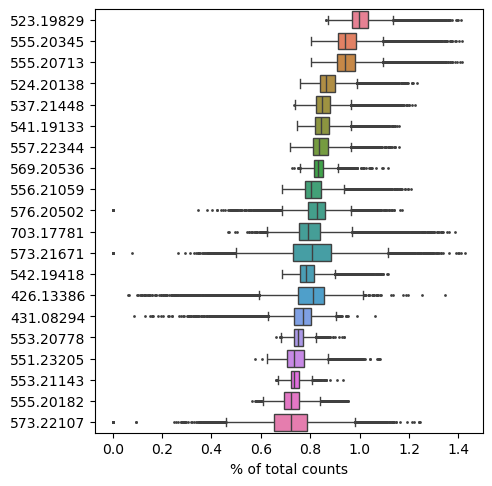

In [19]:
sc.pl.highest_expr_genes(adata, n_top=20, show=True)  # Examine most highly expressed metabolites

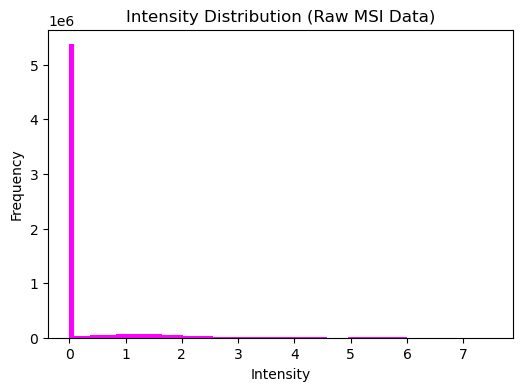

In [20]:
# Optionally, inspect a histogram of intensities:
plt.figure(figsize=(6,4))
plt.hist(adata.X.flatten(), bins=100, color='magenta')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Intensity Distribution (Raw MSI Data)')
plt.show()

In [21]:
# 3. Filter out low-intensity/metabolite peaks:
# Here, we remove features detected in fewer than a certain number of spots.
# Adjust min_cells based on your data (e.g., 5% of total spots)
min_cells = int(0.05 * adata.n_obs)
sc.pp.filter_genes(adata, min_cells=min_cells)
print("Data shape after filtering features:", adata.X.shape)
print("Mincells:", min_cells)


Data shape after filtering features: (5443, 1361)
Mincells: 272


/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [22]:
# Remove highly abundant (since they are most likely noise)
desc = adata.var.n_cells_by_counts.describe()
# Extract the 75% value, then round up to the nearest 50
max_cells_val = int(np.ceil(desc['75%'] / 50.0) * 50)
sc.pp.filter_genes(adata, max_cells=max_cells_val)

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [24]:
np.ceil(desc['75%'] / 50.0) * 50

np.float64(1750.0)

In [25]:
# 4. Normalize and log-transform the data:
# Normalize each spot's total signal (you can adjust the target_sum if needed)
sc.pp.normalize_total(adata, target_sum=1e4)

In [26]:
print("Mean:", np.mean(adata.X), "Std:", np.std(adata.X))


Mean: 9.746588693957108 Std: 29.53640446111193


In [27]:
# 5. Conditional log-transformation:
# Check if the data appears already log-transformed based on a heuristic (e.g., mean value).
# If the mean intensity is low (e.g., below 5), assume it is already log-transformed.
current_mean = np.mean(adata.X)
print("Mean intensity before log-transform check:", current_mean)

if current_mean > 30:
    print("Applying log1p transformation...")
    sc.pp.log1p(adata)
else:
    print("Data appears to be already log-transformed. Skipping log1p.")

print("Data statistics after normalization (and possible log1p transformation):")
print("Mean:", np.mean(adata.X), "Std:", np.std(adata.X))


Mean intensity before log-transform check: 9.746588693957108
Data appears to be already log-transformed. Skipping log1p.
Data statistics after normalization (and possible log1p transformation):
Mean: 9.746588693957108 Std: 29.53640446111193


Spatial smoothing applied. 'denoised' layer created.


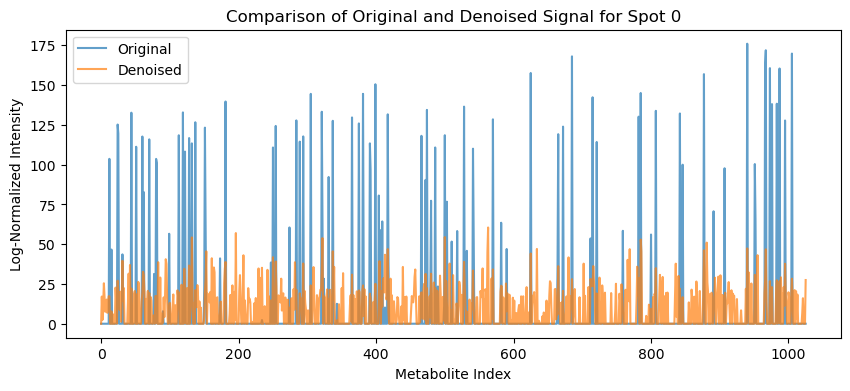

In [28]:
# 5. Spatial Smoothing using Neighbor Averaging:
# We assume that spatial coordinates are stored in adata.obsm['spatial']
if 'spatial' in adata.obsm:
    coords = adata.obsm['spatial']
    # Determine the number of neighbors (including the spot itself)
    n_neighbors = 6  # adjust as needed based on spatial resolution
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    
    # Compute a neighbor-averaged signal for each spot
    X_smoothed = np.array([adata.X[indices[i]].mean(axis=0) for i in range(adata.n_obs)])
    
    # Store the denoised data in a new layer
    adata.layers["denoised"] = X_smoothed
    print("Spatial smoothing applied. 'denoised' layer created.")
    
    # Optional: Compare a spot's original vs. denoised intensities
    spot_idx = 0
    plt.figure(figsize=(10,4))
    plt.plot(adata.X[spot_idx], label='Original', alpha=0.7)
    plt.plot(X_smoothed[spot_idx], label='Denoised', alpha=0.7)
    plt.xlabel('Metabolite Index')
    plt.ylabel('Log-Normalized Intensity')
    plt.title(f'Comparison of Original and Denoised Signal for Spot {spot_idx}')
    plt.legend()
    plt.show()
else:
    print("Spatial coordinates not found in adata.obsm['spatial']. Skipping spatial smoothing.")


/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


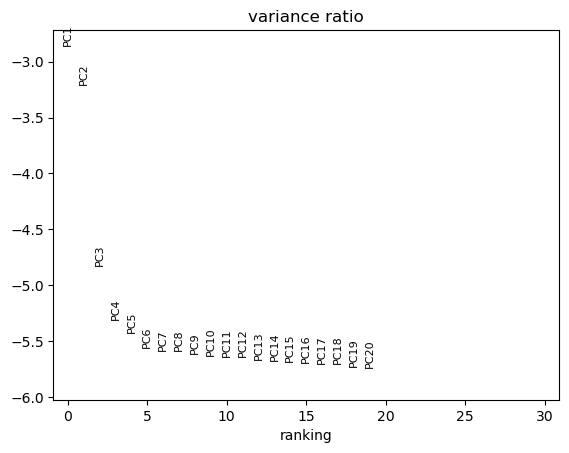

In [29]:
# 6. Dimensionality Reduction for visualization (optional)
sc.tl.pca(adata, n_comps=20, use_highly_variable=False, svd_solver='arpack', layer="denoised")
sc.pl.pca_variance_ratio(adata, log=True, show=True)


In [30]:
adata

AnnData object with n_obs × n_vars = 5443 × 1026
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts', 'denoised'
    obsp: 'connectivities', 'distances'

In [32]:
adata.var["spatialy_highly_variable"] == "True"

289.11568     False
289.11778     False
289.11933     False
289.11988     False
289.12044     False
              ...  
1046.36442    False
1048.32025    False
1048.3319     False
1048.34354    False
1048.38431    False
Name: spatialy_highly_variable, Length: 1026, dtype: bool

In [33]:
# Count the number of True values
print("Number of spatially highly variable features:",
      adata.var["spatialy_highly_variable"].sum())


Number of spatially highly variable features: 67


In [34]:
adata.var["spatialy_highly_variable"].value_counts()

spatialy_highly_variable
False    959
True      67
Name: count, dtype: int64

In [35]:
adata_final = adata[:,adata.var["spatialy_highly_variable"]]

In [36]:
adata_final

View of AnnData object with n_obs × n_vars = 5443 × 67
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts', 'denoised'
    obsp: 'connectivities', 'distances'

In [37]:
import os

In [39]:
split = "half_split"

In [42]:
adata_final.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/hand_prep/", "neuro_msi_denoised.h5ad"))

In [40]:
base_dir = "/lustre/groups/ml01/workspace/eirini.giannakoulia/neuro_denoised"
adata_final_train = adata_final[adata_final.obs[split]=="train"].copy()
adata_final_test = adata_final[adata_final.obs[split]=="test"].copy()

for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    # Create the directory if it doesn't exist
    out_dir = os.path.join(base_dir, feat_sel)
    os.makedirs(out_dir, exist_ok=True)

    # Write the files
    adata_final_train.write(os.path.join(out_dir, "msi_dataset_train.h5ad"))
    adata_final_test.write(os.path.join(out_dir, "msi_dataset_test.h5ad"))


/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
